<p style="text-align:right"><img  src="https://postmba.org/www/wp-content/uploads/2021/10/PostMBA-logo.png" width="150" alt="regression"></p>


<p style="text-align:center"><img  src="utils/images/sarima_model.jpg" width="600" alt="regression"></p>


<p dir=rtl style="direction: rtl;text-align: center;line-height:200%;font-family:vazir;font-size:medium;align:left">
<font face="Arial" size=3><b>
Created by :
Hosein Ahmadi</b>
</font>
</p>


### 1- import packages

In [1]:
import numpy as np
import pmdarima
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import datetime as datetime
import pandas_datareader as pdr
import time
from scipy import signal
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from utils.data_gatherer import *

### 2- define functions and classes

In [4]:
def get_opt_diff(pd_series):
    '''
        function fot best diff for get confidence about stationary of the series with adfuler test
    '''
    
    adf_pvalue = adfuller(pd_series)[1]
    opt_diff = 0
    while True:
        if adf_pvalue > 0.05:
            opt_diff += 1
            pd_series = (pd_series - pd_series.shift(1)).dropna()
            adf_pvalue = adfuller(pd_series)[1]
        else:
            break
    return opt_diff

def get_model_mesage(model_num, p, opt_diff, q, P, D, Q, seasonality, model_aic, duration):
    '''
        a function for print message of the searchong on the models
    '''
    
    msg = (f'Model No. {model_num} ARIMA ({p}, {opt_diff}, {q})({P}, {D}, {Q}) [{seasonality}], AIC = {model_aic}, time = {duration} sec')
    print (msg)

def calculate_best_sarima_model(series, pmax, qmax, Pmax, Qmax, seasonality):
    '''
        a function for searching on models of SARIMA model
    '''
    
    model_count = 0
    best_aic = np.inf
    opt_diff = get_opt_diff(pd_series = series)
    
    seasonality_test = pmdarima.arima.OCSBTest(seasonality, lag_method='aic', max_lag=36)
    D = seasonality_test.estimate_seasonal_differencing_term(series)
    
    for p in range(0, pmax+1):
        for q in range(0, qmax+1):
            for P in range(0, Pmax+1):
                for Q in range(0, Qmax+1):
                    t1 = time.time()
                    model_count += 1
                    arima_model = ARIMA(series,
                                        exog = None,
                                        order = (p, opt_diff, q),
                                        seasonal_order=(P, 1, Q, seasonality),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False,
                                        trend=(0, 0, 1, 0))
                    fitted_arima = arima_model.fit()
                    model_aic = fitted_arima.aic
                    if model_aic<best_aic:
                        best_aic = model_aic
                        optimal_p = P
                        optimal_q = q
                        optimal_P = P
                        optimal_Q = Q
                        
                    t2 = time.time()
                    
                    get_model_mesage(model_count, p, opt_diff,
                                     q, P, D, Q,
                                     seasonality, round(model_aic, 1),
                                     round(t2-t1, 1))
                    
    best_model_params = {'optimal_p': optimal_p, 'optimal_q': optimal_q,
                  'optimal_P': optimal_P, 'optimal_Q': optimal_Q,
                  'opt_diff': opt_diff}
    
    #print best model
    best_model = ARIMA(series,
                        exog = None,
                        order = (optimal_p, opt_diff, optimal_q),
                        seasonal_order=(optimal_P, 1, optimal_Q, seasonality),
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                        trend=(0, 0, 1, 0))
    
    fitted_model = best_model.fit()
    return fitted_model, best_model_params

In [5]:
class sarima_model:
    '''
        main class
    '''
    
    def __init__(self, series, pmax, qmax, Pmax, Qmax, seasonality):
        self.series = series
        self.pamx = pmax
        self.qmax = qmax
        self.Pmax = Pmax
        self.Qmax = Qmax
        self.seasonality = seasonality
        
    def get_optimal_sarima_model(self):
        self.best_model, self.best_params = calculate_best_sarima_model(self.series, self.pamx, self.qmax,
                                                      self.Pmax, self.Qmax, self.seasonality)
        
        print('\n ================= best model ====================')
        print(self.best_params)
        print(self.best_model.summary())
        return self.best_model
        
    def forecast(self, steps, actual_values):
        self.actual = actual_values
        self.fsteps = steps
        self.forecast = self.best_model.forecast(steps = steps, exog = None)
        forecast_data = pd.DataFrame({'Forecast': self.forecast.values, 'Actual': self.actual.values})
        forecast_data.index = actual_values.index
        forecast_data['error'] = 100 * np.abs(((forecast_data['Forecast']/forecast_data['Actual']) - 1).round(3))
        self.forecast_data = forecast_data
        return forecast_data
    
    def plot_forecast(self):
        plt.figure(figsize=(8, 6))
        plt.plot(self.forecast_data['Actual'], label = 'Actual')
        plt.plot(self.forecast_data['Forecast'], label = 'Forecast')
        plt.title('Actual and Forecast values by best Sarima model')
        plt.legend()
        plt.show()

## 3- modelling

> ### GDP

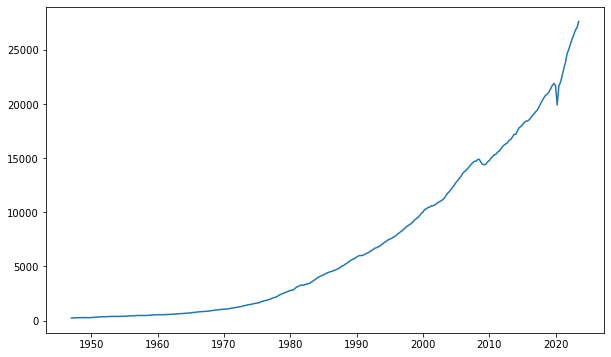

In [4]:
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime(2024, 1, 1)
gdp_data = pdr.data.DataReader('GDP', data_source = 'fred', start = start, end = end)
plt.figure(figsize=(10, 6))
plt.plot(gdp_data)
plt.show()

In [5]:
pmax  = 1 #maximum lag on regular auto regressive
qmax = 1 #maximum lag on regular ma
Pmax = 1 #maximum lag on seasonalty auto regressive
Qmax = 1 #maximum lag on seasonality moving average
fsteps = 12 #steps for forecasting
seasonality = 4

In [6]:
model = sarima_model(gdp_data['GDP'].iloc[:-fsteps], pmax, qmax, Pmax, Qmax, seasonality)
model.get_optimal_sarima_model()

Model No. 1 ARIMA (0, 1, 0)(0, 1, 0) [4], AIC = 3781.2, time = 1.7 sec
Model No. 2 ARIMA (0, 1, 0)(0, 1, 1) [4], AIC = 3715.7, time = 0.1 sec
Model No. 3 ARIMA (0, 1, 0)(1, 1, 0) [4], AIC = 3741.9, time = 0.0 sec
Model No. 4 ARIMA (0, 1, 0)(1, 1, 1) [4], AIC = 3717.5, time = 0.1 sec
Model No. 5 ARIMA (0, 1, 1)(0, 1, 0) [4], AIC = 3753.3, time = 0.0 sec
Model No. 6 ARIMA (0, 1, 1)(0, 1, 1) [4], AIC = 3676.5, time = 0.2 sec
Model No. 7 ARIMA (0, 1, 1)(1, 1, 0) [4], AIC = 3725.9, time = 0.1 sec
Model No. 8 ARIMA (0, 1, 1)(1, 1, 1) [4], AIC = 3677.7, time = 0.2 sec
Model No. 9 ARIMA (1, 1, 0)(0, 1, 0) [4], AIC = 3766.2, time = 0.0 sec
Model No. 10 ARIMA (1, 1, 0)(0, 1, 1) [4], AIC = 3687.2, time = 0.1 sec
Model No. 11 ARIMA (1, 1, 0)(1, 1, 0) [4], AIC = 3714.0, time = 0.1 sec
Model No. 12 ARIMA (1, 1, 0)(1, 1, 1) [4], AIC = 3689.0, time = 0.2 sec
Model No. 13 ARIMA (1, 1, 1)(0, 1, 0) [4], AIC = 3731.0, time = 0.2 sec
Model No. 14 ARIMA (1, 1, 1)(0, 1, 1) [4], AIC = 3677.0, time = 0.2 sec
M

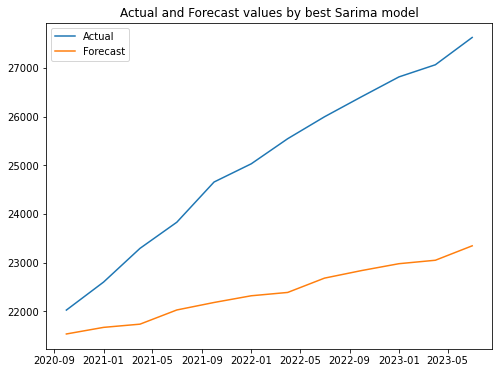

,Forecast,Actual,error
DATE,,,
2020-10-01,21533.878186,22024.502,2.2
2021-01-01,21669.449284,22600.185,4.1
2021-04-01,21735.483953,23292.362,6.7
2021-07-01,22026.994564,23828.973,7.6
2021-10-01,22180.649686,24654.603,10.0
2022-01-01,22318.600672,25029.116,10.8
2022-04-01,22387.015228,25544.273,12.4
2022-07-01,22680.905726,25994.639,12.7
2022-10-01,22836.940735,26408.405,13.5


None

In [7]:
display(model.forecast(steps=fsteps, actual_values = gdp_data['GDP'].iloc[-fsteps:]),
        model.plot_forecast())

> ### Tesla Price

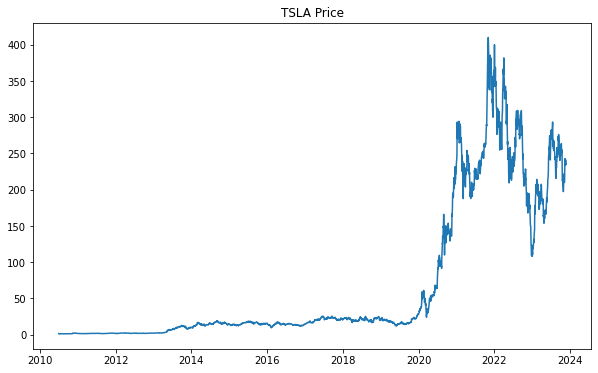

In [8]:
symbol = 'TSLA'
tesla_data = yf.Ticker(symbol).history(period="20y")[['Close']]
plt.figure(figsize=(10, 6))
plt.plot(tesla_data)
plt.title('TSLA Price')
plt.show()

In [9]:
pmax  = 1 #maximum lag on regular auto regressive
qmax = 1 #maximum lag on regular ma
Pmax = 1 #maximum lag on seasonalty auto regressive
Qmax = 1 #maximum lag on seasonality moving average
fsteps = 12 #steps for forecasting
seasonality = 2

model = sarima_model(tesla_data['Close'].iloc[:-fsteps], pmax, qmax, Pmax, Qmax, seasonality)
model.get_optimal_sarima_model()

Model No. 1 ARIMA (0, 1, 0)(0, 0, 0) [2], AIC = 22131.6, time = 0.3 sec
Model No. 2 ARIMA (0, 1, 0)(0, 0, 1) [2], AIC = 19867.1, time = 1.2 sec
Model No. 3 ARIMA (0, 1, 0)(1, 0, 0) [2], AIC = 21048.7, time = 0.1 sec
Model No. 4 ARIMA (0, 1, 0)(1, 0, 1) [2], AIC = 19868.9, time = 2.2 sec
Model No. 5 ARIMA (0, 1, 1)(0, 0, 0) [2], AIC = 22022.6, time = 0.5 sec
Model No. 6 ARIMA (0, 1, 1)(0, 0, 1) [2], AIC = 19861.2, time = 3.4 sec
Model No. 7 ARIMA (0, 1, 1)(1, 0, 0) [2], AIC = 21049.4, time = 0.3 sec
Model No. 8 ARIMA (0, 1, 1)(1, 0, 1) [2], AIC = 19862.5, time = 3.5 sec
Model No. 9 ARIMA (1, 1, 0)(0, 0, 0) [2], AIC = 22133.0, time = 0.1 sec
Model No. 10 ARIMA (1, 1, 0)(0, 0, 1) [2], AIC = 19866.4, time = 1.8 sec
Model No. 11 ARIMA (1, 1, 0)(1, 0, 0) [2], AIC = 21044.5, time = 0.3 sec
Model No. 12 ARIMA (1, 1, 0)(1, 0, 1) [2], AIC = 19867.7, time = 3.0 sec
Model No. 13 ARIMA (1, 1, 1)(0, 0, 0) [2], AIC = 21263.1, time = 1.7 sec
Model No. 14 ARIMA (1, 1, 1)(0, 0, 1) [2], AIC = 19863.1, ti

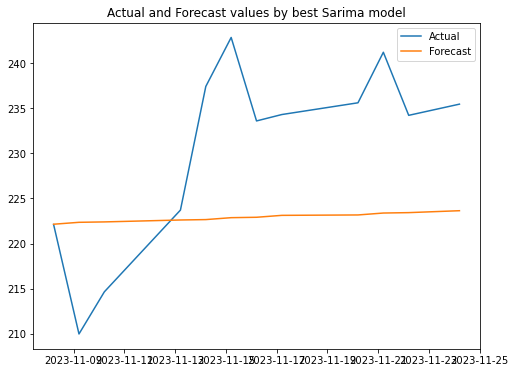

,Forecast,Actual,error
Date,,,
2023-11-08 00:00:00-05:00,222.142495,222.110001,0.0
2023-11-09 00:00:00-05:00,222.354811,209.979996,5.9
2023-11-10 00:00:00-05:00,222.399265,214.649994,3.6
2023-11-13 00:00:00-05:00,222.611655,223.710007,0.5
2023-11-14 00:00:00-05:00,222.656184,237.410004,6.2
2023-11-15 00:00:00-05:00,222.868649,242.839996,8.2
2023-11-16 00:00:00-05:00,222.913252,233.589996,4.6
2023-11-17 00:00:00-05:00,223.125792,234.300003,4.8
2023-11-20 00:00:00-05:00,223.170470,235.600006,5.3


None

In [10]:
display(model.forecast(steps=fsteps, actual_values = tesla_data['Close'].iloc[-fsteps:]), 
        model.plot_forecast())

> ### IranKhodro Price

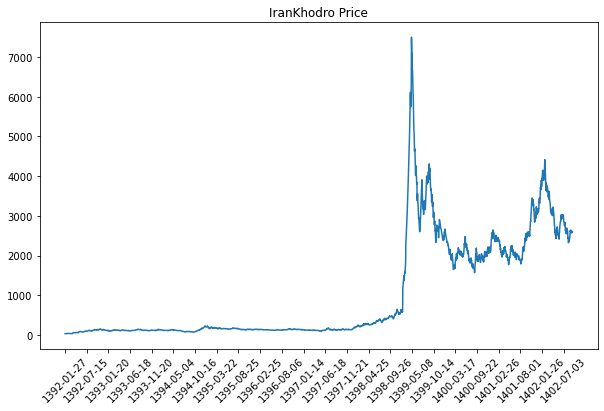

In [11]:
symbol = 'خودرو'
khodro_data = get_daily_price_data(symbol= symbol, start_date='1392-01-01', end_date='1402-09-01')
khodro_data = khodro_data.set_index('jdate')[['Adj Close']]
plt.figure(figsize=(10, 6))
plt.plot(khodro_data)
plt.xticks(khodro_data.index[:len(khodro_data):100], khodro_data.index[:len(khodro_data):100], rotation=45)
plt.title('IranKhodro Price')
plt.show()

In [12]:
pmax  = 1 
qmax = 1 
Pmax = 1 
Qmax = 1 
fsteps = 12
seasonality = 4

model = sarima_model(khodro_data['Adj Close'].iloc[:-fsteps], pmax, qmax, Pmax, Qmax, seasonality)
model.get_optimal_sarima_model()

Model No. 1 ARIMA (0, 1, 0)(0, 0, 0) [4], AIC = 27154.8, time = 0.3 sec
Model No. 2 ARIMA (0, 1, 0)(0, 0, 1) [4], AIC = 25755.4, time = 0.9 sec
Model No. 3 ARIMA (0, 1, 0)(1, 0, 0) [4], AIC = 26391.7, time = 0.1 sec
Model No. 4 ARIMA (0, 1, 0)(1, 0, 1) [4], AIC = 25738.4, time = 1.1 sec
Model No. 5 ARIMA (0, 1, 1)(0, 0, 0) [4], AIC = 27145.4, time = 0.1 sec
Model No. 6 ARIMA (0, 1, 1)(0, 0, 1) [4], AIC = 25697.7, time = 1.8 sec
Model No. 7 ARIMA (0, 1, 1)(1, 0, 0) [4], AIC = 26390.8, time = 0.5 sec
Model No. 8 ARIMA (0, 1, 1)(1, 0, 1) [4], AIC = 25693.5, time = 2.3 sec
Model No. 9 ARIMA (1, 1, 0)(0, 0, 0) [4], AIC = 27156.1, time = 0.1 sec
Model No. 10 ARIMA (1, 1, 0)(0, 0, 1) [4], AIC = 25694.7, time = 2.4 sec
Model No. 11 ARIMA (1, 1, 0)(1, 0, 0) [4], AIC = 26379.9, time = 0.6 sec
Model No. 12 ARIMA (1, 1, 0)(1, 0, 1) [4], AIC = 25693.2, time = 2.1 sec
Model No. 13 ARIMA (1, 1, 1)(0, 0, 0) [4], AIC = 26973.0, time = 1.2 sec
Model No. 14 ARIMA (1, 1, 1)(0, 0, 1) [4], AIC = 25638.9, ti

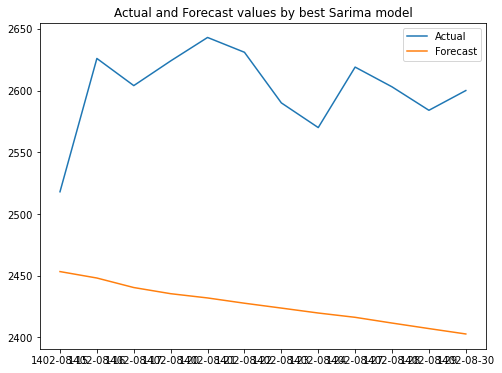

,Forecast,Actual,error
jdate,,,
1402-08-15,2453.342267,2518,2.6
1402-08-16,2448.123033,2626,6.8
1402-08-17,2440.415489,2604,6.3
1402-08-20,2435.427995,2624,7.2
1402-08-21,2431.984946,2643,8.0
1402-08-22,2427.713656,2631,7.7
1402-08-23,2423.775381,2590,6.4
1402-08-24,2419.779125,2570,5.8
1402-08-27,2416.289262,2619,7.7


None

In [13]:
display(model.forecast(steps=fsteps, actual_values = khodro_data['Adj Close'].iloc[-fsteps:]), 
        model.plot_forecast())

> ### Apple Dividens

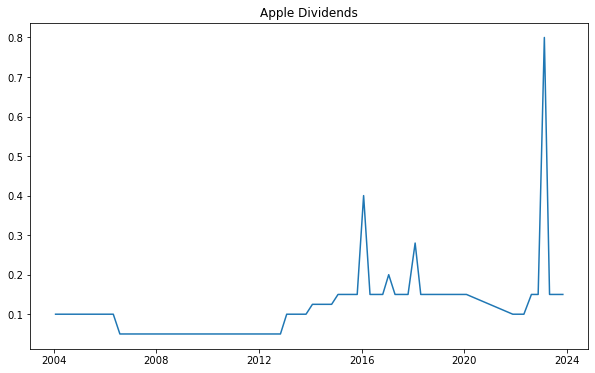

In [19]:
symbol = 'F'
apple_data = yf.Ticker(symbol).history(period="20y")
apple_dividends = apple_data[apple_data['Dividends']>0][['Dividends']]
plt.figure(figsize=(10, 6))
plt.plot(apple_dividends)
plt.title('Apple Dividends')
plt.show()

In [20]:
pmax  = 1 
qmax = 1 
Pmax = 1 
Qmax = 1 
fsteps = 4 
seasonality = 4

model = sarima_model(apple_dividends['Dividends'].iloc[:-fsteps], pmax, qmax, Pmax, Qmax, seasonality)
model.get_optimal_sarima_model()

Model No. 1 ARIMA (0, 1, 0)(0, 1, 0) [4], AIC = -94.4, time = 0.0 sec
Model No. 2 ARIMA (0, 1, 0)(0, 1, 1) [4], AIC = -99.7, time = 0.1 sec
Model No. 3 ARIMA (0, 1, 0)(1, 1, 0) [4], AIC = -103.3, time = 0.0 sec
Model No. 4 ARIMA (0, 1, 0)(1, 1, 1) [4], AIC = -97.9, time = 0.1 sec
Model No. 5 ARIMA (0, 1, 1)(0, 1, 0) [4], AIC = -106.2, time = 0.0 sec
Model No. 6 ARIMA (0, 1, 1)(0, 1, 1) [4], AIC = -107.4, time = 0.1 sec
Model No. 7 ARIMA (0, 1, 1)(1, 1, 0) [4], AIC = -114.1, time = 0.0 sec
Model No. 8 ARIMA (0, 1, 1)(1, 1, 1) [4], AIC = -104.9, time = 0.0 sec
Model No. 9 ARIMA (1, 1, 0)(0, 1, 0) [4], AIC = -102.2, time = 0.0 sec
Model No. 10 ARIMA (1, 1, 0)(0, 1, 1) [4], AIC = -106.0, time = 0.0 sec
Model No. 11 ARIMA (1, 1, 0)(1, 1, 0) [4], AIC = -106.2, time = 0.0 sec
Model No. 12 ARIMA (1, 1, 0)(1, 1, 1) [4], AIC = -104.6, time = 0.1 sec
Model No. 13 ARIMA (1, 1, 1)(0, 1, 0) [4], AIC = -105.4, time = 0.1 sec
Model No. 14 ARIMA (1, 1, 1)(0, 1, 1) [4], AIC = -105.6, time = 0.1 sec
Mode

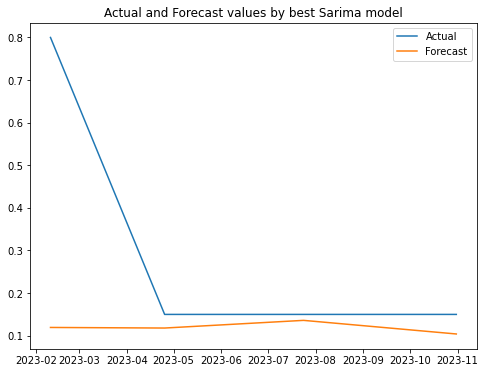

,Forecast,Actual,error
Date,,,
2023-02-10 00:00:00-05:00,0.119384,0.80,85.1
2023-04-25 00:00:00-04:00,0.118013,0.15,21.3
2023-07-24 00:00:00-04:00,0.136018,0.15,9.3
2023-10-31 00:00:00-04:00,0.104081,0.15,30.6


None

In [21]:
display(model.forecast(steps=fsteps, actual_values = apple_dividends['Dividends'].iloc[-fsteps:]),  
        model.plot_forecast())

> ### Foulad Dividens

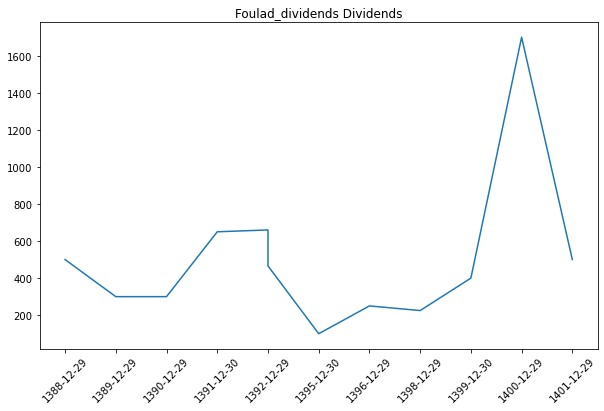

In [17]:
symbol = 'فولاد'
Foulad_dividends = get_stock_dps(symbol)[['DPS']]
plt.figure(figsize=(10, 6))
plt.plot(Foulad_dividends)
plt.title('Foulad_dividends Dividends')
plt.xticks(rotation=45)
plt.show()